Processing steps for estimating intrinsic dimensions and evaluating on simulated curves.

**Nots:** the processing can take about 3 hours with the use of 30 cpus. The results were already saved in "../data/validation/simulation/". You can check the "dim_decomposition_eval_analyse.ipynb" if you want to quickly exploit the results.  

# Packages importation and general configuration

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import random

from scipy import interpolate
from scipy.ndimage.filters import gaussian_filter1d
from scipy.ndimage.measurements import label

from PyAstronomy import pyasl
import pathos.pools as pp

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [2]:
%matplotlib notebook

In [3]:
from genepy3d.obj import curves
from genepy3d.util import geo, plot as mypl

In [4]:
import importlib
importlib.reload(curves);

# Default parameters

In [5]:
# evaluation metric
measure = "f1"

# baseline params
eps_line = 5*1e-5
eps_plane = 5*1e-7

# simulation params
max_seg = 5
nbcrvs = 100
sig_noise_ref = np.arange(0,32,2)
print("sigma of noise:",sig_noise_ref)

nbcases = len(sig_noise_ref)*nbcrvs
print('nb. of cases:',nbcases)

nbcpus = 35
timepercase = 1 # minutes
print('estimated times (min):',(nbcases/nbcpus*timepercase)*1.5)

# remark: parallel pool package preset a random state for every threads
# we need to generate a list of random states for passing to each simulation.
MAXSEED = int(1e4)
seedlst = random.sample(range(MAXSEED),nbcases)

sigma of noise: [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30]
nb. of cases: 1600
estimated times (min): 68.57142857142857


# Unity function

In [6]:
def intrinsic_unity(ite):
    """Unity function for generate simulated curves, estimate intrinsic dimensions, evaluate F1 score
    """
    
    # simulate curve
    sig_crv = sig_noise_ref[ite//nbcrvs]
    model = curves.SimuIntrinsic(max_seg=max_seg,sigma=sig_crv,random_state=seedlst[ite],npoints=1000,spline_order=1)
    
    # init returned data
    data = {}
    data['model'] = model
    
    simu = model.gen()
    if sig_crv==0:
        crvn = simu.get_curve(noisy=False)
        crvd = crvn
        data["estsig"] = 0
    else:
        crvn = simu.get_curve(noisy=True)
        crvd, estsig = crvn.denoise(return_std=True)
        data["estsig"] = estsig
    
    data["crvn"] = crvn
    data["crvd"] = crvd
    
    # minimal nb. of points for a estimated segment
    eps_seg = int(np.round(crvd.coors.shape[0]*0.05)) # 5% of nb. of points
    
    # define scale
#     radius =(crvd.compute_length()/np.pi)*0.15
    if data["estsig"] != 0:
#         radius = 5 * data["estsig"]
        radius = 20
    else:
        radius = 10
        
    radius = 15    
    
    radius_scale_tbl = curves.RadiusScaleTable(crvd,radius)
    sig_c, delta_sig = radius_scale_tbl.compute_scales_from_radius()
    data["sig_c"] = sig_c
    data["delta_sig"] = delta_sig
    
    # proposed method
    try:
        proposed_res = crvd.decompose_intrinsicdim(sig_c,delta_sig,eps_seg_len=eps_seg)
    except:
        data["flag"] = 2 # our estimation error
        return data
    proposed_eva = model.evaluate(proposed_res["line_pred"],proposed_res["planeline_pred"],metric=measure)
    data['proposition'] = [proposed_res["line_pred"], proposed_res["planeline_pred"],proposed_eva]
    data["crvd"] = crvd
    
    # baseline
#     crvs = crvd.convolve_gaussian(sig_c)
    crvs = crvd
    try:
        segs = curves.decompose_intrinsicdim_sequential(crvs.coors,eps_line,eps_plane,eps_seg)
    except:
        data["flag"] = 3 # baseline error
        return data
    bl_eva = model.evaluate(segs[1],segs[2],metric=measure)
    data['baseline'] = [segs[1],segs[2],bl_eva]
    
    data["flag"] = 0 # no errors
    return data

# Test

In [7]:
ite = 179
data = intrinsic_unity(ite)
data

{'model': <genepy3d.obj.curves.SimuIntrinsic at 0x7f8919ceb780>,
 'estsig': 2.01,
 'crvn': <genepy3d.obj.curves.Curve at 0x7f8919cebef0>,
 'crvd': <genepy3d.obj.curves.Curve at 0x7f8919bbcac8>,
 'sig_c': 4.279,
 'delta_sig': 15.767661811441794,
 'proposition': [[[0, 96], [401, 455]],
  [[0, 96], [401, 455]],
  ([0.8821328684028913, 1.0, 0.7934731934731936],
   [0.0, 0.0, 0.0],
   [-1, -1, -1])],
 'baseline': [[[401, 455]],
  [],
  ([0.41353383458646614, 0.5, 0.3525641025641026],
   [-1, -1, -1],
   [-1, -1, -1])],
 'flag': 0}

In [8]:
sig_crv = sig_noise_ref[ite//nbcrvs]
sig_crv

2

<IPython.core.display.Javascript object>


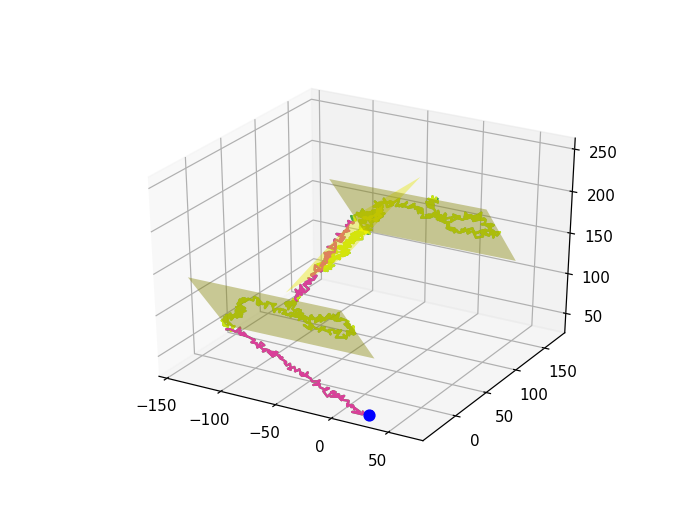

In [9]:
model = data["model"]
fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")
model.plot(ax)

<IPython.core.display.Javascript object>


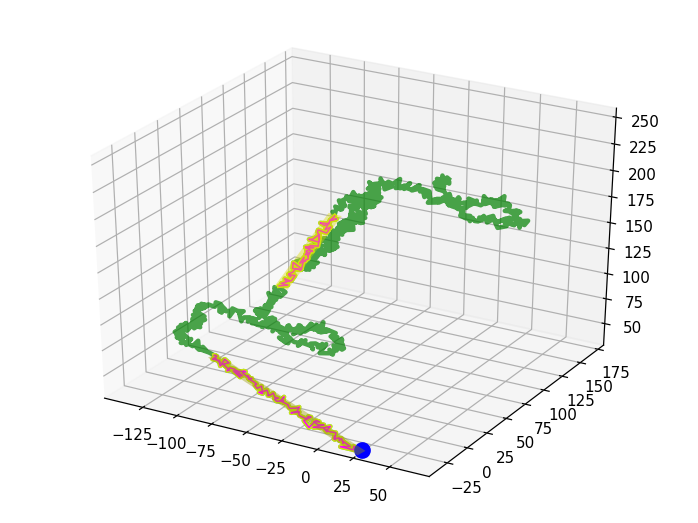

1062.0844238254997


In [10]:
fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")
data["crvd"].plot_intrinsicdim(ax,overrided_curve=data["crvn"]);
print(data["crvd"].compute_length())
plt.tight_layout();

# Parallel computing

In [11]:
pool = pp.ProcessPool(35)

In [12]:
%%time
res = pool.map(intrinsic_unity,range(nbcases))

CPU times: user 5.34 s, sys: 2.44 s, total: 7.77 s
Wall time: 4min 25s


In [13]:
np.save("../data/validation/simulation/simulation_results_30_100_p1000_fixscale_r15.npy",res)